### Ajuste de datos a modelo teorico

Realizacion del ajuste exponenial mediante [**`np.curve.fit`**](np.curve.fit), obteniendo los parametros $V_0$ y $\tau$ correspondientes al modelo de carga.

V0CargaAjuste:  13.381583496975288
tauCargaAjuste:  22.2522530968308


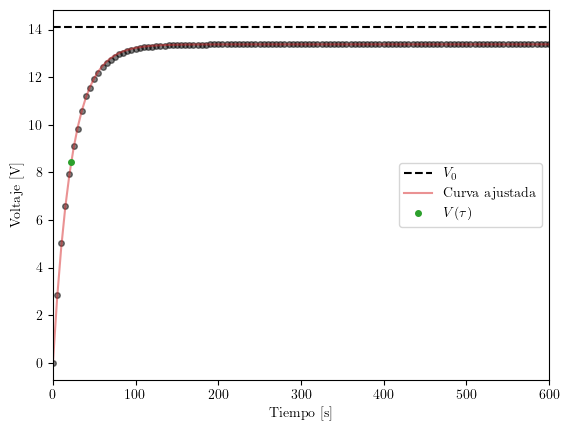

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp


plt.rcParams['text.usetex'] = True

# Generaciond de datos

df1 = pd.read_excel(r"datos.xlsx", sheet_name="datos",
                    usecols="B", skiprows=range(2), nrows=121, header=None)

tiempoCarga = np.arange(0, 605, 5)
voltajeCarga = df1.to_numpy().flatten().transpose()


# Ajuste exponencial
def modeloCarga(x, v0, tau):
    return v0 * (1 - np.exp(-(1/tau) * x))

params, pcov = sp.optimize.curve_fit(modeloCarga, tiempoCarga, voltajeCarga) # Coeficientes
v0CargaAjuste, tauCargaAjuste = params
print("V0CargaAjuste: ", v0CargaAjuste)
print("tauCargaAjuste: ", tauCargaAjuste)
pesoTauCarga = 1/pcov[1][1]

incertidumbre = np.sqrt(np.diag(pcov)) # Calculo la desv stnd con la matriz de covarianza
incertidumbreV0, incertidumbreTau = incertidumbre


# Voltaje en funcion de tau

vTau = modeloCarga(tauCargaAjuste, v0CargaAjuste, tauCargaAjuste) # Esto corresponderia al 63,2% de la carga

# Graficacion

if __name__ == "__main__":

    fix, ax = plt.subplots()

    # Utilizar fuente de Latex
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'

    ax.hlines(14.12, 0, 600, colors="black", ls="--", label="$V_{0}$")
    ax.plot(tiempoCarga, voltajeCarga, "o", color="black", markersize=4, alpha=0.5)
    ax.plot(tiempoCarga, modeloCarga(tiempoCarga, v0CargaAjuste, tauCargaAjuste), '-', color="tab:red", markersize=4, alpha=0.5, label="Curva ajustada")
    ax.plot(tauCargaAjuste, vTau, "o", color="tab:green", markersize=4, label =r"$V(\tau)$")

    plt.xlim(0, 600)
    ax.legend(loc="center right")
    ax.set_xlabel("Tiempo [s]")
    ax.set_ylabel("Voltaje [V]")
    
plt.show()


Realización del ajuste exponenial mediante [**`np.curve.fit`**](np.curve.fit), obteniendo los parametros $V_0$ y $\tau$ correspondientes al modelo de descarga.

V0DescargaAjuste:  13.092351273762134
tauDescargaAjuste:  22.242198494842533


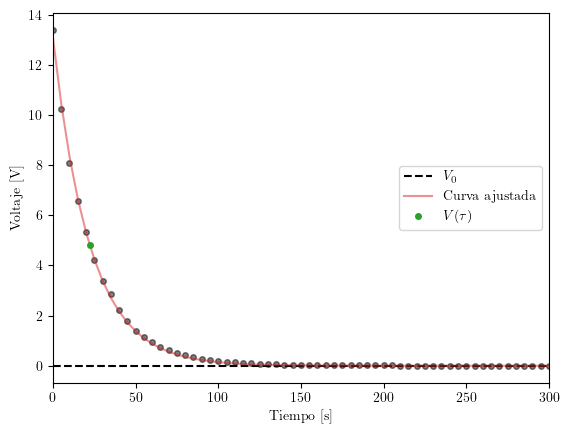

In [13]:

df1 = pd.read_excel(r"datos.xlsx", sheet_name="datos",
                    usecols="D", skiprows=range(2), nrows=61, header=None)

voltajeDescarga = df1.to_numpy().flatten().transpose()
tiempoDescarga = np.arange(0, 305, 5)


# Ajuste exponencial
def modeloDescarga(x, v0, tau):
    return v0*np.exp(-x*(1/tau))

params, pcov = sp.optimize.curve_fit(modeloDescarga, tiempoDescarga, voltajeDescarga) # Coeficientes
v0DescargaAjuste, tauDescargaAjuste = params
print("V0DescargaAjuste: ", v0DescargaAjuste)
print("tauDescargaAjuste: ", tauDescargaAjuste)
pesoTauDescarga = 1/pcov[1][1]
incertidumbre = np.sqrt(np.diag(pcov)) # Calculo la desv stnd con la matriz de covarianza
incertidumbreV0, incertidumbreTau = incertidumbre


# Voltaje en funcion de tau

vTau = modeloDescarga(tauDescargaAjuste, v0DescargaAjuste, tauDescargaAjuste)

# Graficacion

fix, ax = plt.subplots()

# Utilizar fuente de Latex
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

ax.hlines(0, 0, 300, colors="black", ls="--", label="$V_0$")
ax.plot(tiempoDescarga, voltajeDescarga, "o", color="black", markersize=4, alpha=0.5)
ax.plot(tiempoDescarga, modeloDescarga(tiempoDescarga, v0DescargaAjuste, tauDescargaAjuste), '-', color="tab:red", markersize=4, alpha=0.5, label="Curva ajustada")
ax.plot(tauDescargaAjuste, vTau, "o", color="tab:green", markersize=4, label =r"$V(\tau)$")
plt.xlim(0, 300)

ax.legend(loc="center right")
ax.set_xlabel("Tiempo [s]")
ax.set_ylabel("Voltaje [V]")


plt.show()

### Obtencion de la media ponderada de tau

Para obtener una mejor estimacion usando ambos valores, se realiza la media ponderada siguiendo la ecuación

$$
  \overline{\tau}_w = \frac{\sum_{}^{i} \tau_i w_i}{\sum_{}^{i} w_i}
$$

In [14]:
tau = np.array([tauCargaAjuste, tauDescargaAjuste])
pesos = np.array([pesoTauCarga, pesoTauDescarga])

def mediaPon(x, w):
    return (x*w).sum()/w.sum()

def devPon(w):
    return np.sqrt(1/w.sum())

mediaTau = mediaPon(tau, pesos)
incertPon = devPon(pesos)
print("mediaPon: ", mediaPon(tau, pesos))
print("incertPon: ", incertPon)

mediaPon:  22.250891032362198
incertPon:  0.05313523006299384


## Obtención del valor de la capacitancia C
El valor de $R$ es conocido, siendo este igual a $46,4 k \Omega$

$$
   \tau = CR \Rightarrow C = \frac{\tau}{R}
$$

In [15]:
R = 46400 #ohm
C = mediaTau / R
print(C)

0.0004795450653526336


### Graficos de residuos de la carga

Para validar el modelo, se realizan dos graficos, con el fin de ver la distribución respecto al cero.

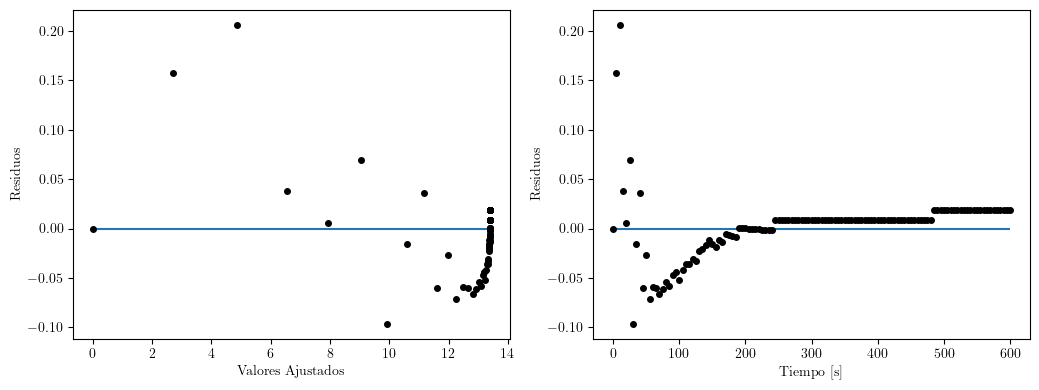

In [16]:
plt.rcParams['text.usetex'] = True

# Ajuste exponencial
def modeloCarga(x, a, tau):
    return a * (1 - np.exp(-(1/tau) * x))

params,_ = sp.optimize.curve_fit(modeloCarga, tiempoCarga, voltajeCarga) # Coeficientes
vPredichoCarga = modeloCarga(tiempoCarga, v0CargaAjuste,tauCargaAjuste)
residuosCarga = voltajeCarga - vPredichoCarga
mediaResiduos = np.mean(residuosCarga)

# Graficacion

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10.5,4))

# Utilizar fuente de Latex
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

ax1.hlines(0, vPredichoCarga.min(), vPredichoCarga.max())
ax1.plot(vPredichoCarga, residuosCarga, "o", color="black", markersize=4)
ax1.set_xlabel("Valores Ajustados")
ax1.set_ylabel("Residuos")
#ax1.set_ylim([residuos.min()-0.11, residuos.max()+0.01])

ax2.hlines(0, tiempoCarga.min(), tiempoCarga.max())
ax2.plot(tiempoCarga, residuosCarga, "o", color="black", markersize=4)
ax2.set_ylabel("Residuos")
ax2.set_xlabel("Tiempo [s]")

plt.tight_layout()

plt.show()

### Graficos de residuos de la descarga

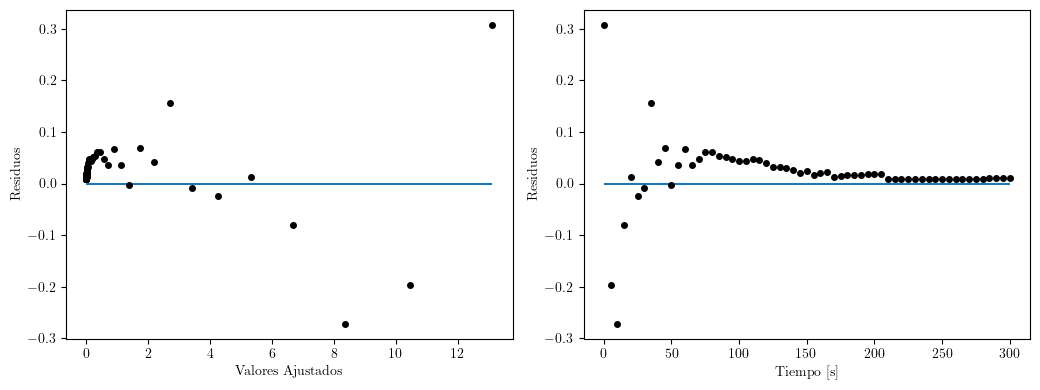

In [17]:
plt.rcParams['text.usetex'] = True

# Generaciond de datos

df1 = pd.read_excel(r"F:\Facultad\Laboratorios\EyM\Lab2\datos.xlsx", sheet_name="datos",
                    usecols="D", skiprows=range(2), nrows=61, header=None)

tiempoDescarga = np.arange(0, 305, 5)
voltajeDescarga = df1.to_numpy().flatten().transpose()

# Ajuste exponencial
def modeloDescarga(x, v0, tau):
    return v0 * np.exp(-x * (1 / tau))


params, _ = sp.optimize.curve_fit(modeloDescarga, tiempoDescarga, voltajeDescarga)  # Coeficientes
v0Ajuste, tauAjuste = params
vPredicho = modeloDescarga(tiempoDescarga, v0Ajuste, tauAjuste)
residuos = voltajeDescarga - vPredicho

# Graficacion

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10.5,4))

# Utilizar fuente de Latex
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

ax1.hlines(0, vPredicho.min(), vPredicho.max())
ax1.plot(vPredicho, residuos, "o", color="black", markersize=4)
ax1.set_xlabel("Valores Ajustados")
ax1.set_ylabel("Residuos")

ax2.hlines(0, tiempoDescarga.min(), tiempoDescarga.max())
ax2.plot(tiempoDescarga, residuos, "o", color="black", markersize=4)
ax2.set_ylabel("Residuos")
ax2.set_xlabel("Tiempo [s]")

plt.tight_layout()


plt.show()

### Coeficiente de Determinación $R^2$

Se calcula como dato extra, no se suele utilizar en modelos exponenciales

$$

R^2 = 1 - \frac{\sum_{i=1}^N (V_{\text{exp}, i} - V_{\text{pred}, i})^2}{\sum_{i=1}^N (V_{\text{exp}, i} - \overline{V}_{\text{exp}})^2}

$$

In [18]:
vCargaMedia = np.average(voltajeCarga)
r2Carga = 1 - (sum((voltajeCarga-modeloCarga(tiempoCarga,v0CargaAjuste,tauCargaAjuste))**2)/sum((voltajeCarga-vCargaMedia)**2))
print("r2Carga: ", r2Carga)

vDescargaMedia = np.average(voltajeDescarga)
r2Descarga = 1 - (sum((voltajeDescarga-modeloDescarga(tiempoDescarga,v0DescargaAjuste,tauDescargaAjuste))**2)/sum((voltajeDescarga-vDescargaMedia)**2))
print("r2Descarga: ", r2Descarga)


r2Carga:  0.9996845668167458
r2Descarga:  0.9992799146194881
